# Thermal Testing Data Processing Tool

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import os
import warnings
warnings.filterwarnings('ignore')

from xlsxwriter.utility import xl_rowcol_to_cell

import pandas.io.formats.excel
pandas.io.formats.excel.header_style = None

In [2]:
tool_start = datetime.datetime.now()

# Control Panel
Define variables for test (Project title, temperature limits, duration, rounding requirements)

In [3]:
#Set file name here.  File must be in data folder in same directory as tool.
file = 'data/19-0XX-RD-02-RD.xlsm'
#Set project title to appear in graphs.
project_title = 'Bio Rad C-064 & C-170 Dry Ice Comparison'

#Set temperature limits
upper_limit = -20
lower_limit = -95

#Set duration requirements
duration = 0

#Set rounding requirements
round = 1

#set isc identifier digits (ISC1-ISC9; digit=1: ISC10-ISC99; digit=2)
digit = 1

#Consider air probes in analysis?
air_probes=False

In [4]:
if not os.path.exists(f'output/{project_title}'):
                      os.mkdir(f'output/{project_title}')
                      
# if not os.path.exists(f'tables/{project_title}'):
#                       os.mkdir(f'tables/{project_title}')  

writer = pd.ExcelWriter(f'output/{project_title}/{project_title}_Analysis.xlsx', engine='xlsxwriter')
workbook = writer.book

## Read file

In [5]:
#Read in raw data file from test output .xlsm
df_raw=pd.read_excel(file)

#Determine which row the test data begins
for row in range(df_raw.shape[0]):
    for col in range(df_raw.shape[1]):
        if df_raw.iat[row, col] == 'Date Time':
            row_start = row
        break

#Read in raw data file begining with test data
df_data = pd.read_excel(file, skiprows=row_start+1)

drop_col = df_data.columns[1]
drop_col

if drop_col == 'Watlow':
    df_data = df_data.drop(columns=[drop_col, "Over Limit"])
else:
    df_data = df_data.drop(columns=drop_col)
    df_data = df_data.loc[:, :'Over Limit']
    df_data = df_data.drop(columns="Over Limit")

## Data Cleanup

In [6]:
#Set index to Date Time Column
df_data_index = df_data.set_index('Date Time')
df_chart = df_data.set_index('Date Time')

#Get thermocouple names used in testing
tc_names = list(df_chart)

#Sort thermocouples by type (Ambient, Air, or Product)
ambs = [tc_name for tc_name in tc_names if "AMB" in tc_name]
airs = [tc_name for tc_name in tc_names if "AIR" in tc_name]
prds = [tc_name for tc_name in tc_names if "PRD" in tc_name]

#Get number of unique shipper IDs (ISC1, ISC2, etc)
groups = list(df_chart)

#Create list of shippers (ISC1, ISC2, etc)
num_index = 100
shippers = []
for item in groups:
    if "AMB" not in item:
        end = 7 + digit
        shippers.append(item[4:end])
        num = int(item[7:end])
        if num <= num_index:
            num_index = num
            
#Determine number of shippers tested by shipper ID
max_shippers = len(set(shippers))

## Calculate Elapsed Time

In [7]:
#Convert values to date and time values for calculations
datetime = pd.to_datetime(df_data['Date Time'], dayfirst=True)
datetime = pd.to_timedelta(datetime)
df_formatted = df_data
df_formatted['Date Time'] = pd.to_datetime(df_formatted['Date Time'])

#Store start time of test as variable
start_time = df_formatted['Date Time'].iloc[0]

#Calcuate elapsed time at each data point and store into new column
df_formatted['Elapsed Time'] = df_formatted['Date Time'] - start_time

#Convert elapsed time to hours
df_formatted['Elapsed Time (Hours)'] = ((df_formatted["Elapsed Time"].dt.total_seconds())/3600).round(round)

#Round to decimal places as indicated in control panel
elapsed_time = df_formatted['Elapsed Time (Hours)'].round(round)

#Set new index to be elapsed time in hours
df_chart = df_formatted.set_index('Elapsed Time (Hours)')
df_chart = df_chart.drop(columns=['Elapsed Time', 'Date Time'])

In [8]:
end_test = df_chart.index[-1]
end_test

215.7

## Filter data by performance period

In [9]:
#Create dataframe of values only within the required performance period for calculations
df_dur = df_chart
df_dur = df_dur.reset_index()
df_dur = df_dur[df_dur['Elapsed Time (Hours)'] < (duration+.1)]
df_dur = df_dur.set_index('Elapsed Time (Hours)')
df_dur = df_dur.drop(columns=ambs)
if air_probes == False:
    df_dur = df_dur.drop(columns=airs, axis=1)

In [10]:
# Add a format. Light red fill with dark red text.
format1 = workbook.add_format({'bg_color': '#FFC7CE',
                               'font_color': '#9C0006',
                                'align' : 'center'})

# Add a format. Green fill with dark green text.
format2 = workbook.add_format({'bg_color': '#C6EFCE',
                               'font_color': '#006100',
                               'align' : 'center'})

if round == 2:
    temp_format = workbook.add_format({'num_format': '0.00', 'align': 'center'})
else:
    temp_format = workbook.add_format({'num_format': '0.0', 'align': 'center' })
    
cell_format = workbook.add_format({'align':'center'})

In [11]:
df_chart.columns

Index(['PRD-ISC1-C064-PUR-100ML-TC23', 'PRD-ISC2-C064-ePUR-100ML-TC24',
       'AMB-RIGHT-TC25', 'AMB-LEFT-TC26', 'AIR-ISC1-C064-PUR-TC34',
       'AIR-ISC2-C064-ePUR-TC36', 'PRD-ISC3-C170-PUR-TC37',
       'AIR-ISC3-C170-PUR-TC38', 'PRD-ISC4-C170-ePUR-TC39',
       'AIR-ISC4-C170-ePUR-TC40'],
      dtype='object')

In [12]:
df_chart.to_excel(writer, sheet_name='AllData')


worksheet = writer.sheets['AllData']
worksheet.set_column(0, 0, 10, cell_format)
worksheet.set_column(1, len(df_chart.columns), 10, cell_format)

chart_columns = df_chart.columns
for column in range(len(chart_columns)):
    if chart_columns[column] not in ambs:
        #print(column, chart_columns[column])

        worksheet.conditional_format(1, column+1, len(df_chart),column+1,
                                     {'type': 'cell',
                                      'criteria': 'not between',
                                      'minimum': lower_limit,
                                      'maximum': upper_limit,
                                      'format': format1
        })

        worksheet.conditional_format(1, column+1, len(df_chart),column+1,
                                     {'type': 'cell',
                                      'criteria': 'between',
                                      'minimum': lower_limit,
                                      'maximum': upper_limit,
                                      'format': format2
        })

# Graphs - All
Includes all test data.

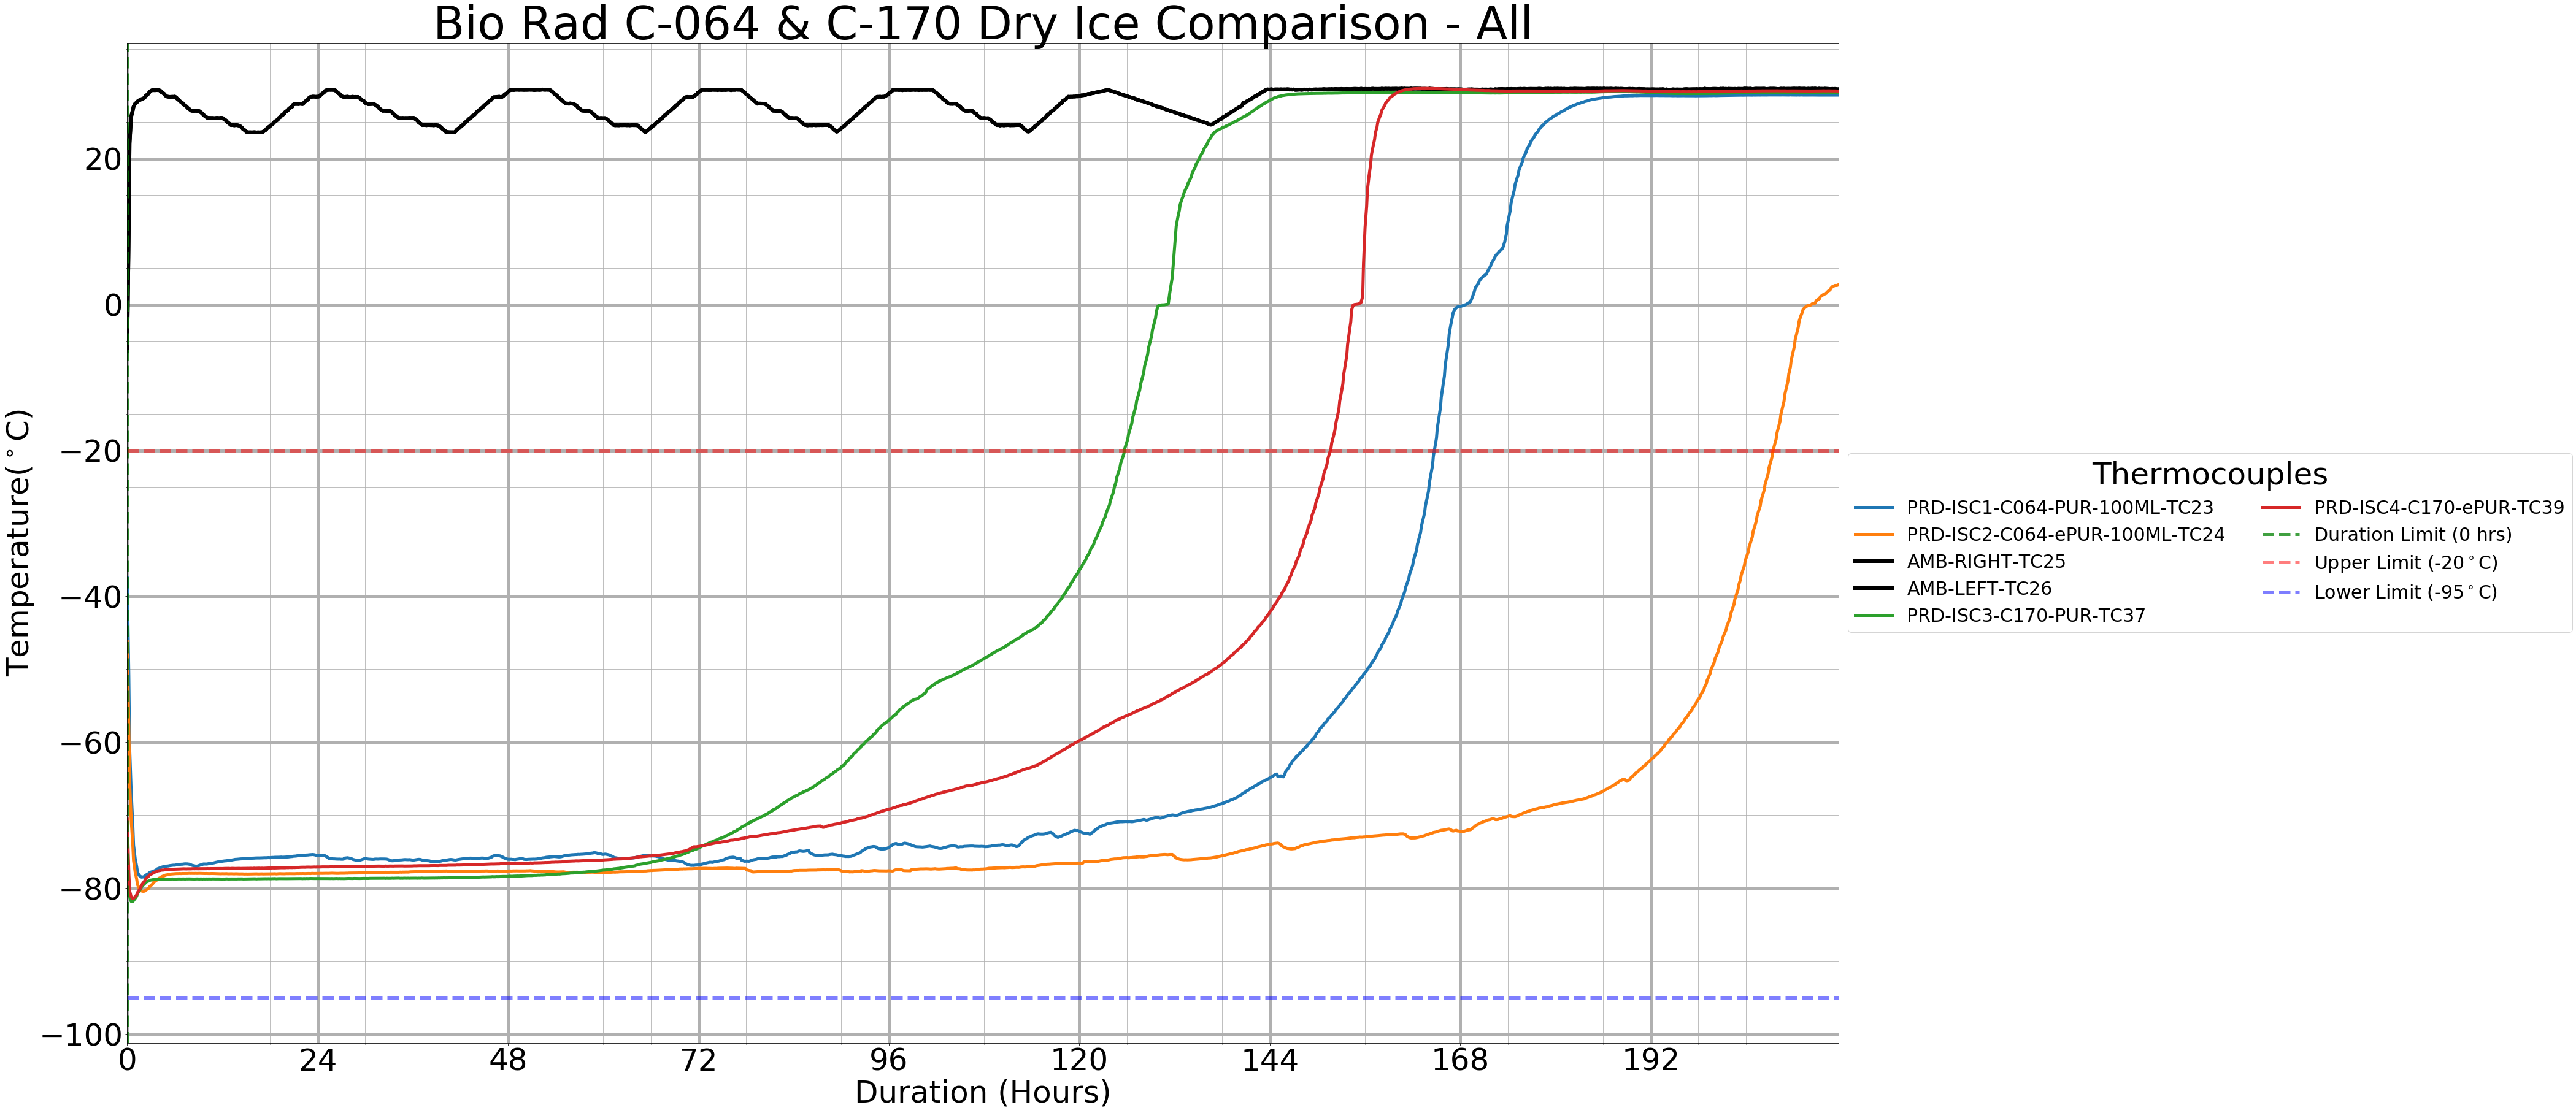

In [13]:
figsize=(50,30)
fig1, ax1 = plt.subplots(figsize=figsize)
fontsize=50
linewidth=5

major_ticks = np.arange(0, end_test, 24)
minor_ticks = np.arange(0, end_test, 12)

#Plot all probes
for i in df_chart:
    if i in ambs:
        ax1.plot(df_chart[i], color='black', lw=1.2*linewidth)
    if i in prds:
        ax1.plot(df_chart[i], lw=linewidth)
    if air_probes==True:
        if i in airs:
            ax1.plot(df_chart[i], alpha=.5, lw=linewidth)
    ax1.set_xticks(major_ticks, minor=False)
    ax1.set_xticks(minor_ticks, minor=True)
    ax1.grid(True, which='both')
    plt.minorticks_on()


#Format graph title, axis, and grid
plt.title(f'{project_title} - All', fontsize=fontsize*1.5)
plt.xlabel('Duration (Hours)', fontsize=fontsize)
plt.ylabel('Temperature($^\circ$C)', fontsize=fontsize)
plt.xlim(0,end_test)

#Add duration line (vertical), add upper and lower temp limits
plt.axvline(x=duration, alpha=.75, linestyle='--', color='green', label=f"Duration Limit ({duration} hrs)", linewidth=linewidth)
plt.axhline(y=upper_limit, alpha=.5, linestyle='--', color='red', label=f'Upper Limit ({upper_limit}$^\circ$C)', linewidth=linewidth)
plt.axhline(y=lower_limit, alpha=.5, linestyle='--', color='blue', label=f'Lower Limit ({lower_limit}$^\circ$C)', linewidth=linewidth)

#Add legend
leg = plt.legend(loc='center left', bbox_to_anchor=(1, .5), title='Thermocouples', ncol=2, fontsize=30)
leg.set_title('Thermocouples',prop={'size':fontsize})

plt.tick_params(axis='both', which='major', labelsize=50)
plt.grid(linewidth=linewidth)


#Save figure
plt.savefig(f'output/{project_title}/{project_title}-All.png', bbox_inches='tight')
plt.show()

# Graphs - Individual
Includes all test data.

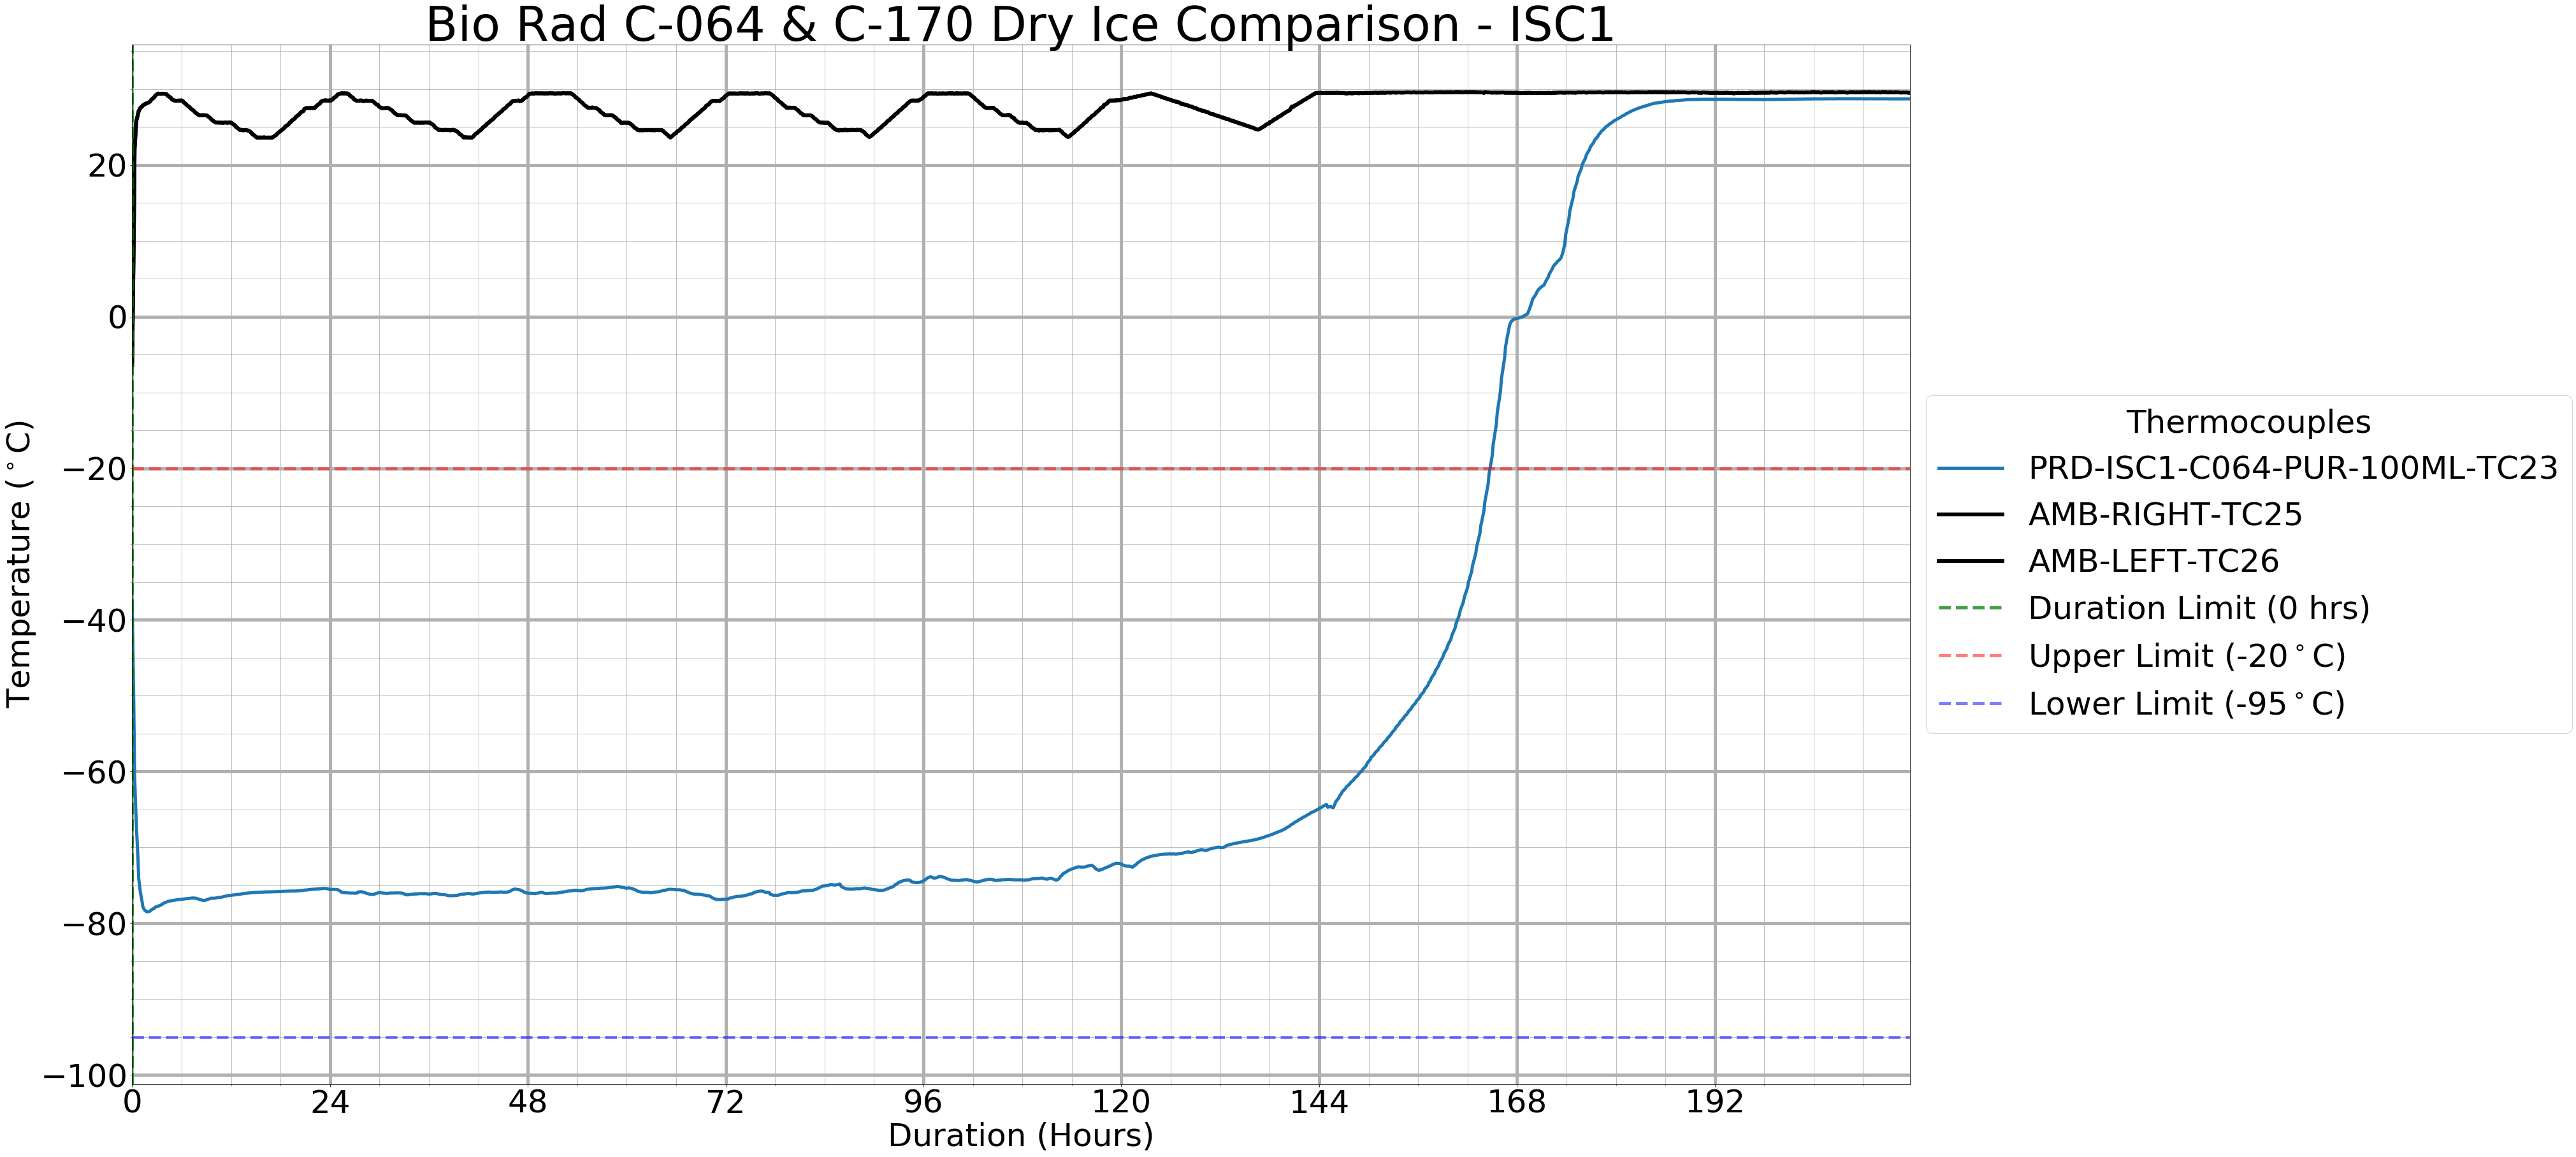

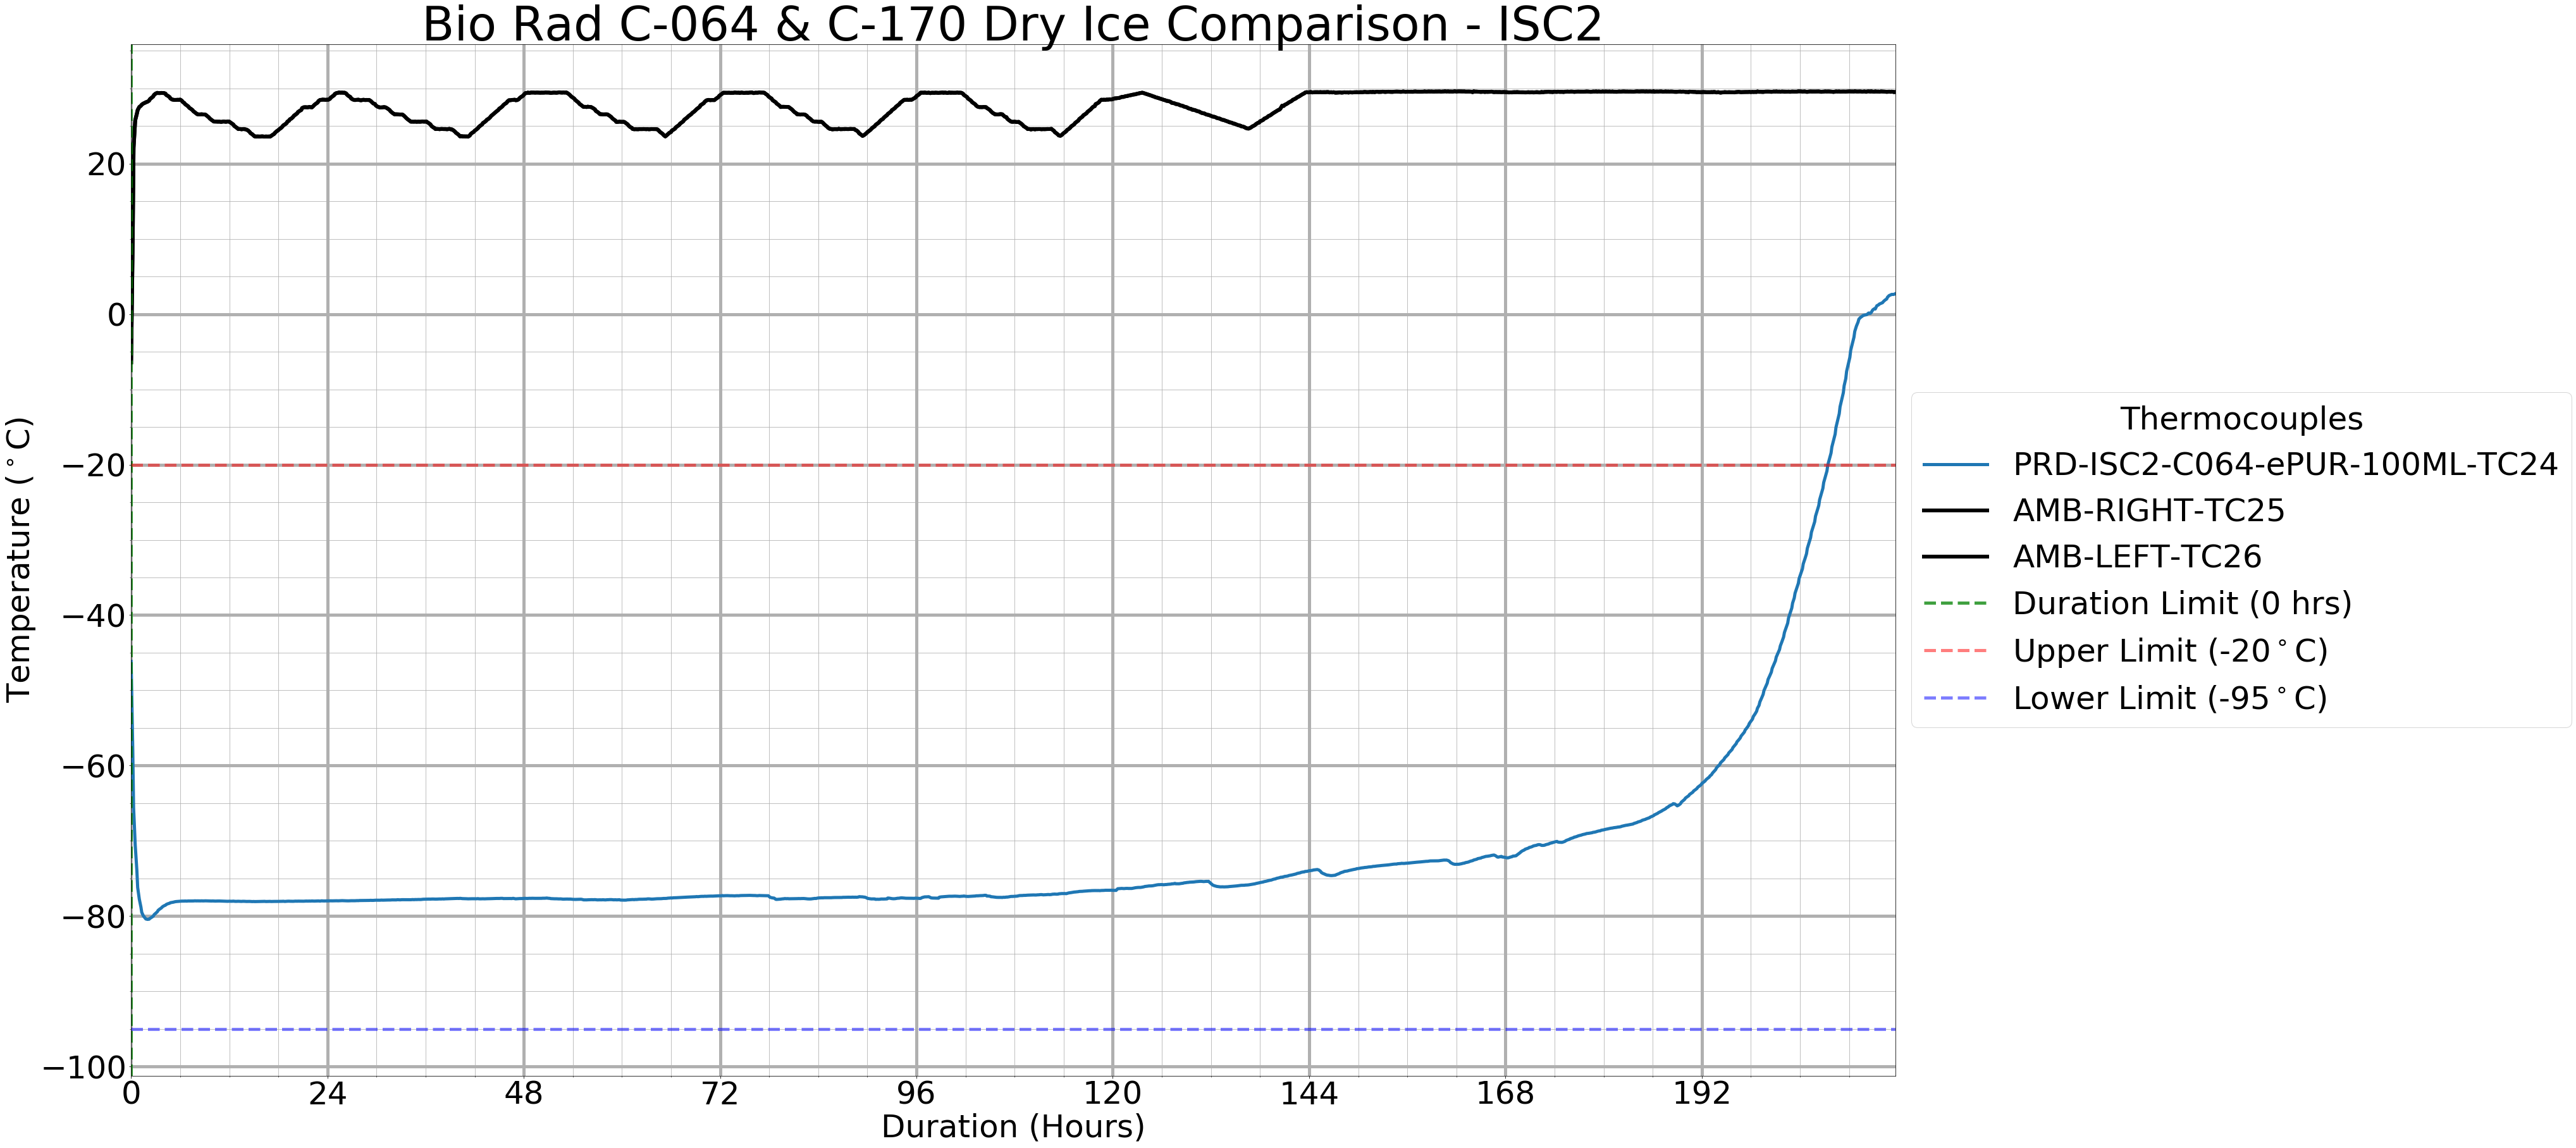

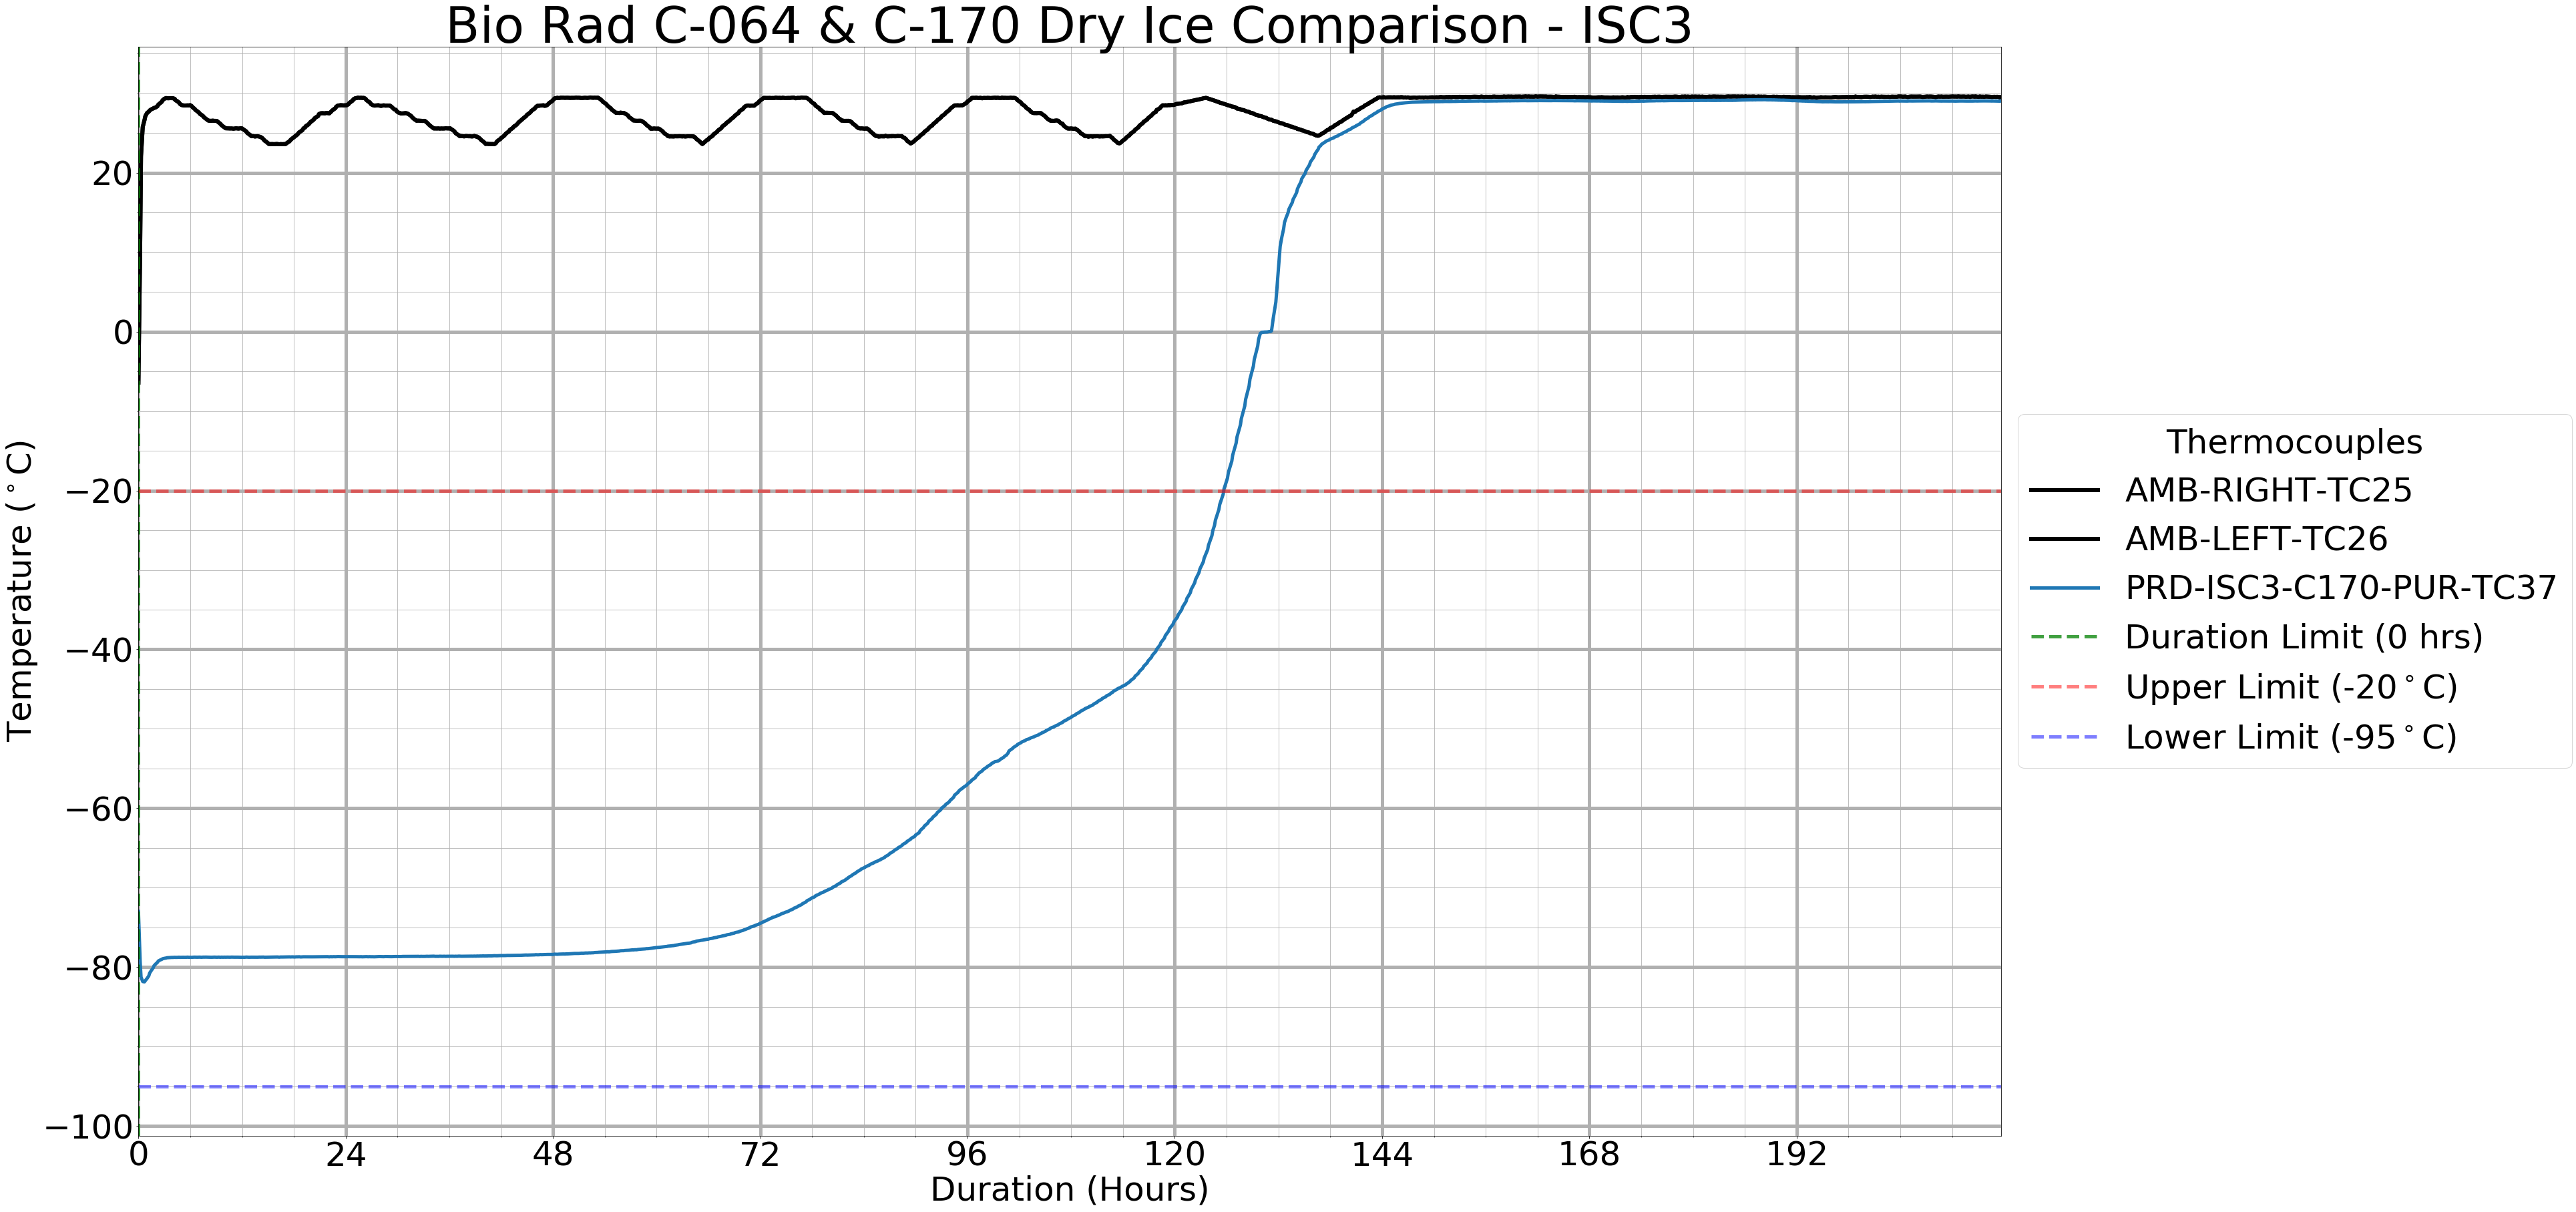

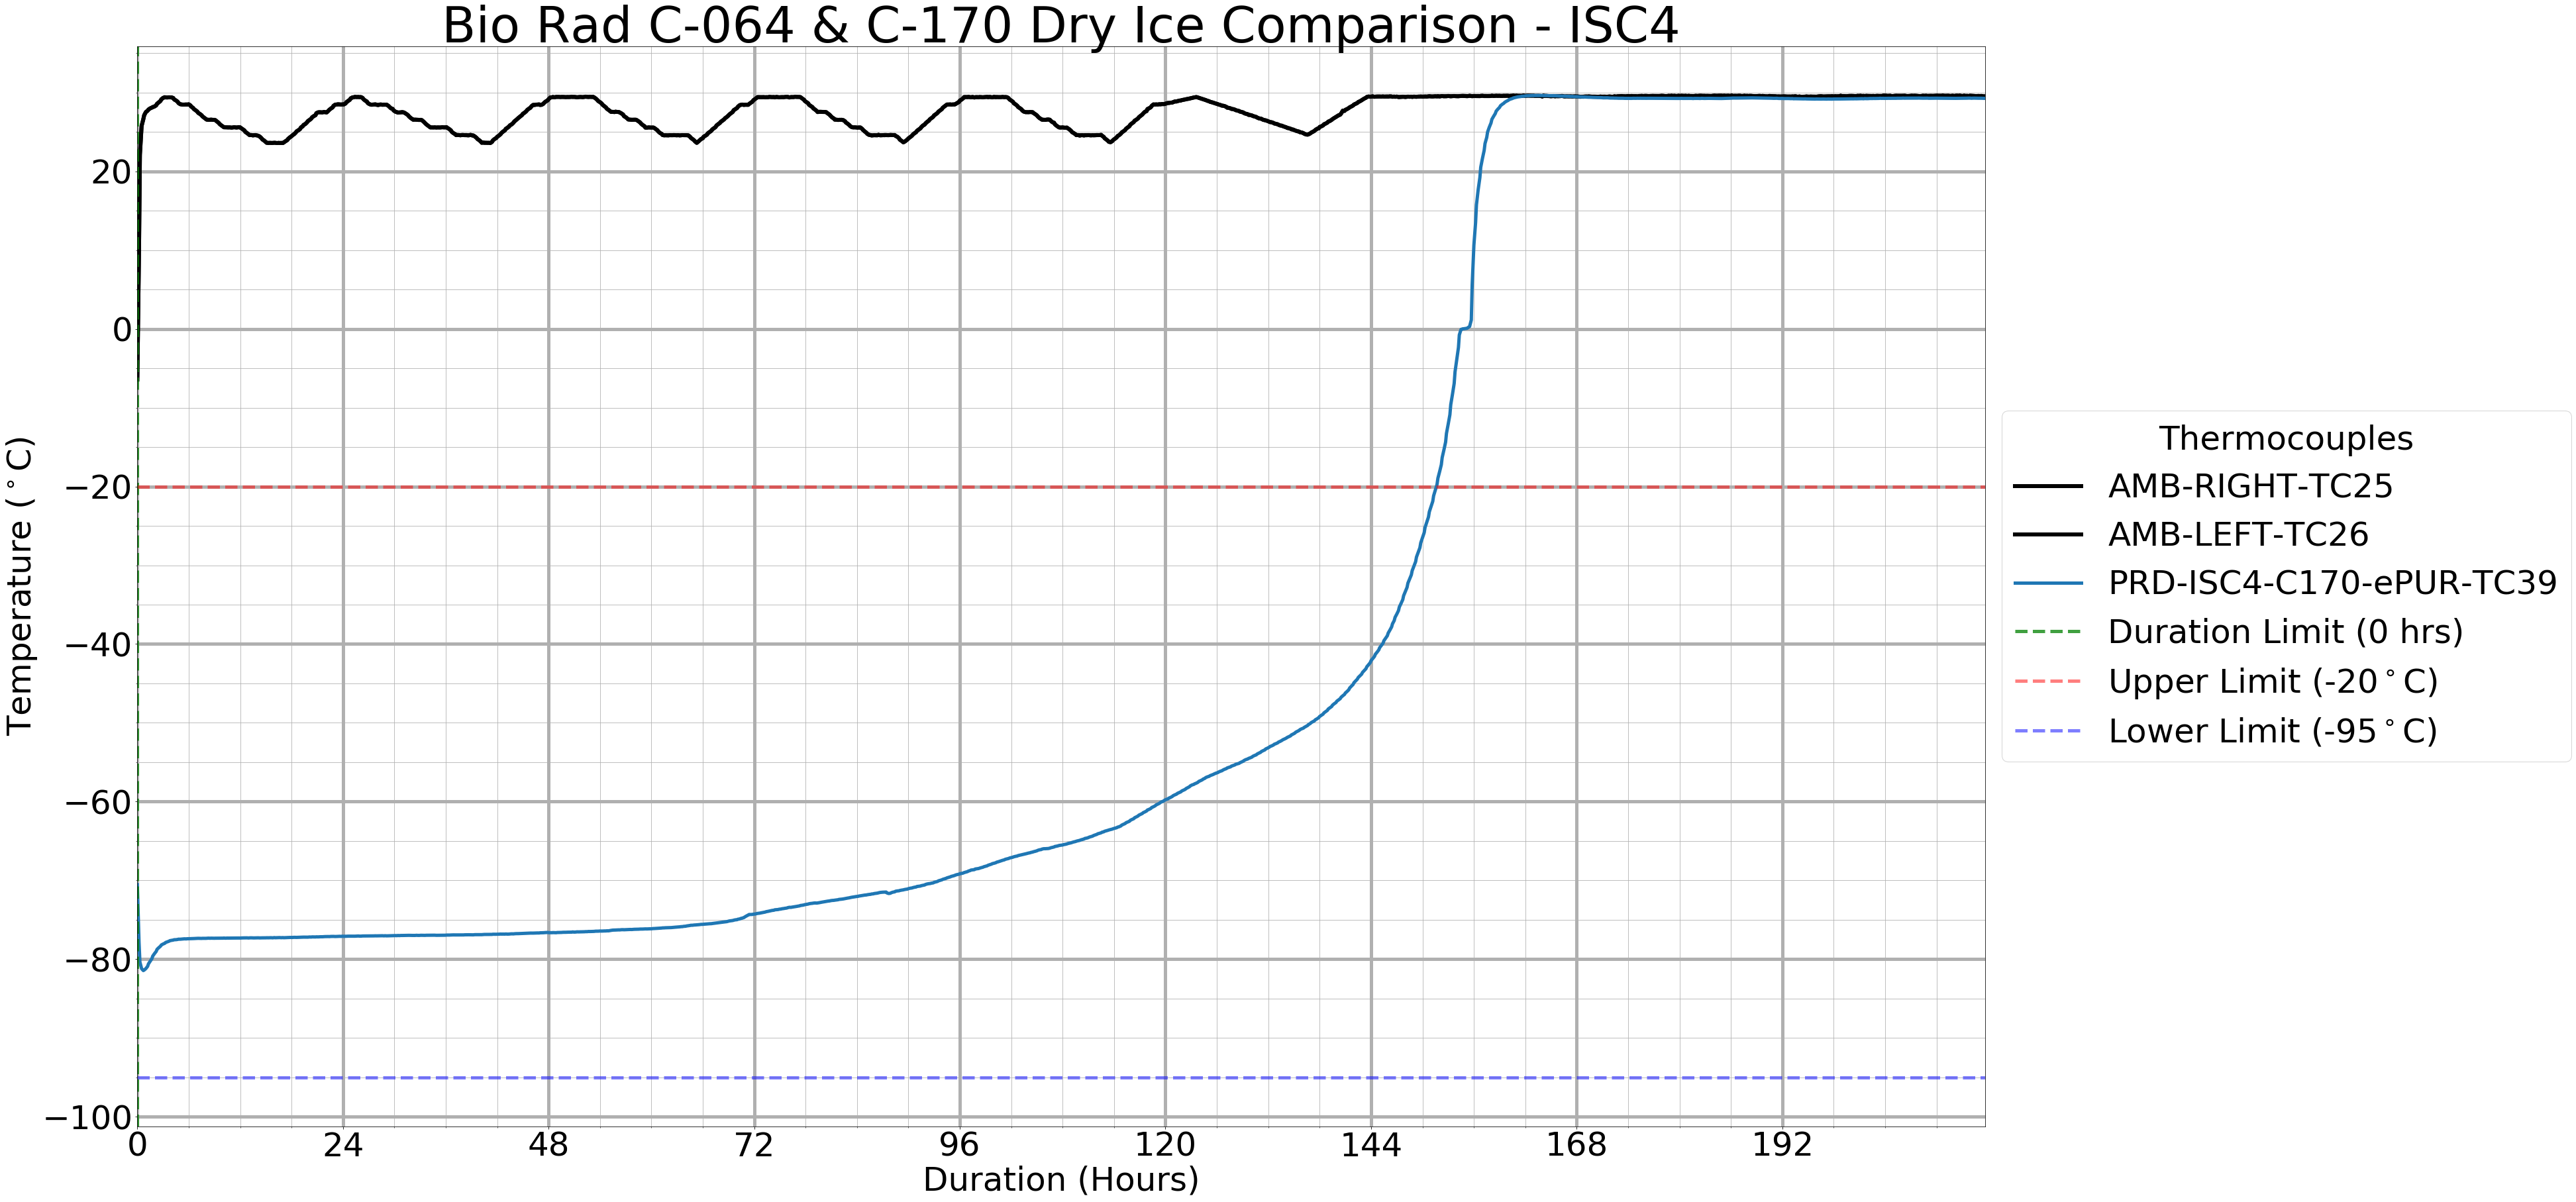

In [14]:
#Loop through each unique shipper ID and graph all probes
for x in range(max_shippers):
    fig1, ax1 = plt.subplots(figsize=(figsize))
    isc = f'ISC{x+num_index}'
    ISC = [tc_name for tc_name in tc_names if str(isc) in tc_name]
    for i in df_chart:
        if i in ISC:
            if i in prds:
                ax1.plot(df_chart[i], lw=linewidth)
            if air_probes==True:
                if i in airs:
                    ax1.plot(df_chart[i], lw=linewidth)
        if i in ambs:
            ax1.plot(df_chart[i], color='black', lw=1.2*linewidth)
        ax1.set_xticks(major_ticks, minor=False)
        ax1.set_xticks(minor_ticks, minor=True)
        ax1.grid(True, which='both')
        plt.minorticks_on()

    plt.title(f'{project_title} - {isc}', fontsize=fontsize*1.5)
    plt.xlabel('Duration (Hours)', fontsize=fontsize)
    plt.ylabel('Temperature ($^\circ$C)', fontsize=fontsize)
    plt.xlim(0,end_test)
    
    plt.axvline(x=duration, alpha=.75, linestyle='--', color='green', label=f"Duration Limit ({duration} hrs)", linewidth=linewidth)
    plt.axhline(y=upper_limit, alpha=.5, linestyle='--', color='red', label=f'Upper Limit ({upper_limit}$^\circ$C)', linewidth=linewidth)
    plt.axhline(y=lower_limit, alpha=.5, linestyle='--', color='blue', label=f'Lower Limit ({lower_limit}$^\circ$C)', linewidth=linewidth)
    
    plt.xticks(major_ticks)
    
    plt.tick_params(axis='both', which='major', labelsize=50)
    plt.grid(linewidth=linewidth)
    
    leg = plt.legend(loc='center left', bbox_to_anchor=(1, .5), title='Thermocouples', ncol=1, fontsize=fontsize)
    leg.set_title('Thermocouples',prop={'size':fontsize})
    plt.savefig(f'output/{project_title}/{project_title}-{isc}.png', bbox_inches='tight')
    plt.show()

# Temperature Analysis - All Probes
Ignores values outside of performance period

In [15]:
#calculate minimum and maximum temps rounded to required digits
min_temps = df_dur.min().round(round)
max_temps = df_dur.max().round(round)

#create temperature table dataframe
temp_table = pd.DataFrame({
    'Minimum Temp' : min_temps,
    'Maximum Temp' : max_temps})


#initialize lists for temperature checks
lower_check = []
upper_check = []
pass_check = []

#loop through dataframe and check each min/max temps against lower/upper limits
for i in temp_table['Minimum Temp']:
    if i < lower_limit:
        under_temp = i-lower_limit
        lower_check.append(f'Failed by {under_temp: .2f} deg')
    else:
        lower_check.append('Pass')
        
for i in temp_table['Maximum Temp']:
    if i > upper_limit:
        over_temp = i - upper_limit
        upper_check.append(f'Failed by {over_temp: .2f} deg')
    else:
        upper_check.append('Pass')

temp_table['Lower Limit Check'] = lower_check
temp_table['Upper Limit Check'] = upper_check

#determine overall pass/fail criteria
temp_table['Thermal Result'] = np.where(temp_table['Lower Limit Check'] != "Pass", "Failed Lower Limit",
                                   np.where(temp_table['Upper Limit Check'] != "Pass", 'Failed Upper Limit', 'Pass'))

#Re-arrange columns in table
temp_table = temp_table[['Minimum Temp', 'Lower Limit Check', 'Maximum Temp', 'Upper Limit Check', 'Thermal Result']]


# Temperature Analysis - By Shipper ID
Ignores values outside of performance period.

In [16]:
#Create summary table.  Shippers will be grouped by Shipper ID
temp_table_summary = temp_table[['Maximum Temp', 'Minimum Temp']]

#Categorize each TC name by Shipper ID and add to list
tc_groups = []
for name in temp_table_summary.index:
    for b in range(max_shippers):
        isc = f'ISC{b+num_index}'
        if isc in name:
            tc_groups.append(isc)

#Add shipper ID to table
temp_table_summary['Shipper'] = tc_groups

#Calculate min/max temperatures by temperature ID
temp_table_summary_min = temp_table_summary.groupby('Shipper')['Minimum Temp'].min()
temp_table_summary_max = temp_table_summary.groupby('Shipper')['Maximum Temp'].max()

#create summary table dataframe
summary_df = pd.DataFrame({
    'Minimum Temp' : temp_table_summary_min,
    'Maximum Temp' : temp_table_summary_max
})

#initialize lists for temperature checks
lower_check_group = []
upper_check_group = []
pass_check_group = []

#loop through dataframe and check each min/max temps against lower/upper limits
for i in summary_df['Minimum Temp']:
    if i < lower_limit:
        under_temp = lower_limit - i
        lower_check_group.append(f'Failed by {under_temp: .2f} deg')
    else:
        lower_check_group.append('Pass')
        
for i in summary_df['Maximum Temp']:
    if i > upper_limit:
        over_temp = i - upper_limit
        upper_check_group.append(f'Failed by {over_temp: .2f} deg')
    else:
        upper_check_group.append('Pass')

#determine pass/fail criteria by temperature and overall pass/fail      
summary_df['Lower Limit Check'] = lower_check_group
summary_df['Upper Limit Check'] = upper_check_group
summary_df['Thermal Result'] = np.where(summary_df['Lower Limit Check'] != "Pass", "Failed Lower Limit",
                                   np.where(summary_df['Upper Limit Check'] != "Pass", 'Failed Upper Limit', 'Pass'))

#Rearrange and show summary dataframe
summary_df = summary_df[['Minimum Temp', 'Lower Limit Check', 'Maximum Temp', 'Upper Limit Check', 'Thermal Result']]
#summary_df.to_excel(writer, sheet_name='TempsbyShipper')
#summary_df

# Duration Analysis - All Probes

In [17]:
# #Create dataframe from data to do duration analysis
df_dur_all = df_chart
df_dur_all = df_dur_all.drop(columns=ambs, axis=1)

#filter air probes if required
if air_probes == False:
    df_dur_all = df_dur_all.drop(columns=airs, axis=1)

#create duration dictionary to store analysis 
dict_df = {}

#determine index (elapsed hours) when the temperature is outside of allowable limits
#store index into dictionary
for col in df_dur_all:
    x = np.where((df_dur_all[col] < lower_limit) | (df_dur_all[col] > upper_limit))
    dict_df[col] = x[0]

#create list of index and tc name
dur_index = []
dur_names = []

#loop through dictionary to determine the time (index) at which probes failed
for key, value in dict_df.items():
    if len(value) > 0: #if the dictionary has data, length will be greater than 0
        dur_index.append(value[0]) #store the first value the probe failed
        dur_names.append(key)
    else: #if the dictionary key is empty, the probe never went out of spec
        dur_index.append(len(df_dur_all)) #store the maximum value of dataframe (index + 1)
        dur_names.append(key)
    
#subtract 1 from all index values to capture the LAST point when the probe was in spec
dur_index = [value - 1 for value in dur_index]

#create list of the durations by plugging the index into the duratino dataframe
dur_hours = df_dur_all.iloc[dur_index].index    

#convert lists to dataframe
dur_df_summary = pd.DataFrame({
    'TC Name' : dur_names,
    'Duration (Hours)': dur_hours
})

#check for pass/fail based on duration requirements
for i in dur_df_summary['Duration (Hours)']:
    if i >= duration:
        pass_check.append('Pass')
    else:
        short_time = duration - i
        pass_check.append(f'Failed by {short_time: .2f} hours')

#add column to dataframe
dur_df_summary['Duration Result'] = pass_check

#Rename index and show table
dur_df_summary = dur_df_summary.set_index("TC Name")
#dur_df_summary.to_excel(writer, sheet_name='DurationbyProbes')
#dur_df_summary

# Duration Analysis - By Shipper ID

In [18]:
#Create dataframe from data to do duration analysis
dur_df2 = dur_df_summary.reset_index()

#Add column of TC groups
dur_df2['Shipper'] = tc_groups

#Calculate the duration of the Shipper ID by grabbing the lowest duration value
dur_df2_min = dur_df2.groupby('Shipper')['Duration (Hours)'].min()

#Create summary dataframe
dur_summary = pd.DataFrame(dur_df2_min)

#initialize pass/check list
pass_check = []

#check for pass/fail based on duration requirements
for i in dur_summary['Duration (Hours)']:
    if i >= duration:
        pass_check.append('Pass')
    else:
        short_time = duration - i
        pass_check.append(f'Failed by {short_time: .2f} hours')

#add column to dataframe
dur_summary['Duration Result'] = pass_check


In [19]:
summary_all = pd.concat([summary_df, dur_summary], axis=1)
summary_all.to_excel(writer, sheet_name='SummaryByISC')

worksheet=writer.sheets['SummaryByISC']
worksheet.set_column('A:H', 17, cell_format)
#worksheet.set_column(0, len(summary_all), cell_format)

summary_all

,Minimum Temp,Lower Limit Check,Maximum Temp,Upper Limit Check,Thermal Result,Duration (Hours),Duration Result
Shipper,,,,,,,
ISC1,-37.4,Pass,-37.4,Pass,Pass,164.6,Pass
ISC2,-46.2,Pass,-46.2,Pass,Pass,207.4,Pass
ISC3,-73.0,Pass,-73.0,Pass,Pass,125.6,Pass
ISC4,-70.5,Pass,-70.5,Pass,Pass,151.5,Pass


In [20]:
summary_isc = pd.concat([temp_table, dur_df_summary], axis=1)
summary_isc.to_excel(writer, sheet_name='SummaryByProbe')

worksheet=writer.sheets['SummaryByProbe']
worksheet.set_column('A:H', 17, cell_format)
#worksheet.set_column(0, len(summary_isc), cell_format)

summary_isc

,Minimum Temp,Lower Limit Check,Maximum Temp,Upper Limit Check,Thermal Result,Duration (Hours),Duration Result
TC Name,,,,,,,
PRD-ISC1-C064-PUR-100ML-TC23,-37.4,Pass,-37.4,Pass,Pass,164.6,Pass
PRD-ISC2-C064-ePUR-100ML-TC24,-46.2,Pass,-46.2,Pass,Pass,207.4,Pass
PRD-ISC3-C170-PUR-TC37,-73.0,Pass,-73.0,Pass,Pass,125.6,Pass
PRD-ISC4-C170-ePUR-TC39,-70.5,Pass,-70.5,Pass,Pass,151.5,Pass


# Export Tabular Data to Excel

In [21]:
df_excel = df_formatted.set_index('Date Time')
df_excel = df_excel.round(decimals=round)

for x in range(max_shippers):
    isc = f'ISC{x+num_index}'
    ISC = [tc_name for tc_name in tc_names if str(isc) in tc_name]
    ISC.insert(0, 'Elapsed Time (Hours)')
    df_excel1 = df_excel[ISC]
    df_excel1.to_excel(writer, sheet_name=f'Duration - {isc}')
    worksheet = writer.sheets[f'Duration - {isc}']
    worksheet.set_column('A:A', 20, cell_format)
    worksheet.set_column(1, len(df_excel1.columns), 10, temp_format)
    worksheet.conditional_format(1,2,len(df_excel1), len(df_excel1.columns),
                                 {'type': 'cell',
                                  'criteria': 'not between',
                                  'minimum': lower_limit,
                                  'maximum': upper_limit,
                                  'format': format1
    })
    
    worksheet.conditional_format(1,2,len(df_excel1), len(df_excel1.columns),
                                 {'type': 'cell',
                                  'criteria': 'between',
                                  'minimum': lower_limit,
                                  'maximum': upper_limit,
                                  'format': format2
    })
    
    number_rows = len(df_excel1)
    number_cols = len(df_excel1.columns)
    
    worksheet.merge_range(number_rows+1, 0, number_rows+1, 1, "Maximum Temperature")
    worksheet.merge_range(number_rows+2, 0, number_rows+2, 1, "Minimum Temperature")
    
    for column in range(2, number_cols+1):
        cell_location = xl_rowcol_to_cell(number_rows+1, column)
        start_range = xl_rowcol_to_cell(1, column)
        end_range = xl_rowcol_to_cell(number_rows, column)
        formula = "=MAX({:s}:{:s})".format(start_range, end_range)
        worksheet.write_formula(cell_location, formula)
    
    for column in range(2, number_cols+1):
        cell_location = xl_rowcol_to_cell(number_rows+2, column)
        start_range = xl_rowcol_to_cell(1, column)
        end_range = xl_rowcol_to_cell(number_rows, column)
        formula = "=MIN({:s}:{:s})".format(start_range, end_range)
        worksheet.write_formula(cell_location, formula)
    


In [22]:
sheet_names = ['AllData', 'SummaryByProbe', 'SummaryByISC']

duration_names = []

for x in range(max_shippers):
    isc = f'ISC{x+num_index}'
    ISC = [tc_name for tc_name in tc_names if str(isc) in tc_name]
    name = f'Duration - {isc}'
    duration_names.append(name)
    
sheets = sheet_names + duration_names

In [23]:
border_format=workbook.add_format({
                            'border':1,
                            'align':'left',
                            'font_size':10
                           })

header_format = workbook.add_format({'bold':True, 'text_wrap':True, 'align':'center'})

for sheet in sheets:
    worksheet = writer.sheets[sheet]
    worksheet.conditional_format('A1:BB1000' , { 'type' : 'no_blanks' , 'format' : border_format})
    worksheet.set_row(0, None, header_format)

writer.save()

In [24]:
import datetime
tool_end = datetime.datetime.now()
tool_duration = (tool_end - tool_start).total_seconds()
print(f'Total Runtime of data processing: {tool_duration: .2f} seconds')

Total Runtime of data processing:  9.71 seconds
